# Biquadratic Coupling STO Demo

Demonstration of the biquadratic coupling term in spin torque oscillator (STO).

The free layer and the fixed layer of the STO coupled via biquadratic coupling term, which allows magneitude higher electric current density to excite the STO so as to achieve higher frequency.


Example taken from the paper:

Liu, Chuhan, et al. "High-frequency spin torque oscillation in orthogonal magnetization disks with strong biquadratic magnetic coupling." Scientific reports 13.1 (2023): 3631.


The notebook compares the frequency of the STO with and without biquadratic coupling term using Ni and FePt as the free and fixed layer materials respectively (Figure 5c i in the paper).



Note: The simulator used in the paper is a custom LLG equation solver which changes the electron polarization of the spin current based on the simulated fixed layer and expliclitly calculates the amount of electrons tunnelling through the spacer into the free layer. 
I don't agree with this approach since the actual device being fabricated has a way thicker fixed layer than the 2nm in the simulation to obtain a PMA. The fixed layer in the simulation here is only for coupling purposes and does not affect the slonczewski torque field.


Implemented by Jed Cheng (jed.cheng@mag.ed.kyushu-u.ac.jp)

In [1]:
from magnumnp import *
import torch
from matplotlib import pyplot as plt
import numpy as np
from scipy.fft import rfft, rfftfreq
%config InlineBackend.figure_format = 'retina'

2024-03-27 11:15:37  magnum.np:INFO magnum.np 1.1.5


Without biquadratic coupling

In [2]:

Timer.enable()
torch.set_default_dtype(torch.float32)



# initialize mesh
n  = (64, 64, 3)
dx = (5e-9, 5e-9, 2e-9)
mesh = Mesh(n, dx)
# state = State(mesh, device="cpu")
state = State(mesh, device="cuda")

state.material = {
        "A": 1.3e-11,
        "P": 0.57,
        "Lambda": 2.25,
        "epsilon_prime": -0.1,
        "mp": state.Tensor((0, 0.01, 0.99)),
        "d": 2e-9,
        "J": 1.5e11
        }


# Ni
r = 160e-9
x, y, z = state.SpatialCoordinate()
free = ((x-r)/r)**2 + ((y-r)/r)**2 < 1 
fixed = ((x-r)/r)**2 + ((y-r)/r)**2 < 1 

free[:,:,1:3] = False
fixed[:,:,0:2] = False


# Set initial magnetization
state.m = state.Constant([0, 0, 0])
state.m[free] = state.Tensor([0, 0.99, 0.01])
state.m[fixed] = state.Tensor([0, 0.01, 0.99])



alpha = state.Constant([0.0])
alpha[free] = 0.0088
alpha[fixed] = 1


Ku = state.Constant([0.0]) 
Ku[free] = 51
Ku[fixed] = 600000


Ms = state.Constant([0.0])
Ms[free] = 510e3
Ms[fixed] = 800e3


Ku_axis = state.Constant([1, 0, 0])
Ku_axis[free] = state.Tensor([1, 1, 0])
Ku_axis[fixed] = state.Tensor([0, 0, 1])


state.material['alpha'] = alpha
state.material['Ms'] = Ms
state.material['Ku'] = Ku
state.material['Ku_axis'] = Ku_axis


exchange_free = ExchangeField(free)
exchange_fixed = ExchangeField(fixed)
aniso     = UniaxialAnisotropyField()
demag    = DemagField()
torque   = SpinTorqueSlonczewski()


llg = LLGSolver([demag, exchange_free, exchange_fixed, aniso])
llg.relax(state, silent=True)

llg = LLGSolver([demag, aniso, exchange_fixed, exchange_free, torque,])
logger = ScalarLogger("data/m.dat", ['t', 'm'])
eps = 1e-15
with open("data/free_no_BQ.dat", "w") as f:
        with open("data/fixed_no_BQ.dat", "w") as g:
                while state.t < 10e-9-eps:
                        llg.step(state, 5e-12, silent=True)
                        logger << state

                        free_ = state.m[free].average()
                        fixed_ = state.m[fixed].average()

                        f.write(f"{state.t} {free_[0].item()} {free_[1].item()} {free_[2].item()}\n")
                        g.write(f"{state.t} {fixed_[0].item()} {fixed_[1].item()} {fixed_[2].item()}\n")

Timer.print_report()

2024-03-22 20:03:46  magnum.np:INFO [State] running on device: cuda (dtype = float32)
2024-03-22 20:03:46  magnum.np:INFO [Mesh] 64x64x3 (size= 5e-09 x 5e-09 x 2e-09)
2024-03-22 20:03:47  magnum.np:INFO [LLGSolver] using RKF45 solver (atol = 1e-05)
2024-03-22 20:03:47  magnum.np:INFO [DEMAG]: Time calculation of demag kernel = 0.11355924606323242 s
2024-03-22 20:04:00  magnum.np:INFO [LLGSolver] using RKF45 solver (atol = 1e-05)



TIMER REPORT
Operation                        No of calls    Avg time [ms]    Total time [s]
-----------------------------  -------------  ---------------  ----------------
LLGSolver.relax                            1    13018.7               13.0187
    DemagField.h                        4234        0.522634           2.21283
    ExchangeField.h                     8468        1.13948            9.64914
    UniaxialAnisotropyField.h           4234        0.061329           0.259667
LLGSolver.step                          2001       96.5673           193.231
    DemagField.h                       72720        0.501431          36.4641
    UniaxialAnisotropyField.h          72720        0.0647663          4.70981
    ExchangeField.h                   145440        0.859606         125.021
    SpinTorqueSlonczewski.h            72720        0.0962192          6.99706
-----------------------------  -------------  ---------------  ----------------
Total                                   

With biquadratic coupling

In [3]:

Timer.enable()
torch.set_default_dtype(torch.float32)

B_BQ = -0.6e-3

# initialize mesh
n  = (64, 64, 3)
dx = (5e-9, 5e-9, 2e-9)
mesh = Mesh(n, dx)
# state = State(mesh, device="cpu")
state = State(mesh, device="cuda")

state.material = {
        "A": 1.3e-11,
        "P": 0.57,
        "Lambda": 2.25,
        "epsilon_prime": -0.1,
        "mp": state.Tensor((0, 0.01, 0.99)),
        "d": 2e-9,
        "J": 1.5e11
        }


# Ni
r = 160e-9
x, y, z = state.SpatialCoordinate()
free = ((x-r)/r)**2 + ((y-r)/r)**2 < 1 
fixed = ((x-r)/r)**2 + ((y-r)/r)**2 < 1 

free[:,:,1:3] = False
fixed[:,:,0:2] = False


# Set initial magnetization
state.m = state.Constant([0, 0, 0])
state.m[free] = state.Tensor([0, 0.99, 0.01])
state.m[fixed] = state.Tensor([0, 0.01, 0.99])



alpha = state.Constant([0.0])
alpha[free] = 0.0088
alpha[fixed] = 1


Ku = state.Constant([0.0]) 
Ku[free] = 51
Ku[fixed] = 600000


Ms = state.Constant([0.0])
Ms[free] = 510e3
Ms[fixed] = 800e3


Ku_axis = state.Constant([1, 0, 0])
Ku_axis[free] = state.Tensor([1, 1, 0])
Ku_axis[fixed] = state.Tensor([0, 0, 1])


state.material['alpha'] = alpha
state.material['Ms'] = Ms
state.material['Ku'] = Ku
state.material['Ku_axis'] = Ku_axis


exchange_free = ExchangeField(free)
exchange_fixed = ExchangeField(fixed)
rkky      = BiquadraticField(B_BQ, "z", 0, 2)
aniso     = UniaxialAnisotropyField()

demag    = DemagField()

torque   = SpinTorqueSlonczewski()



llg = LLGSolver([demag, exchange_free, exchange_fixed, aniso])
llg.relax(state, silent=True)


llg = LLGSolver([demag, aniso, exchange_fixed, exchange_free, torque, rkky])
logger = ScalarLogger("data/m.dat", ['t', 'm'])
eps = 1e-15
with open("data/free_w_BQ.dat", "w") as f:
        with open("data/fixed_w_BQ.dat", "w") as g:
                while state.t < 10e-9-eps:
                        llg.step(state, 5e-12, silent=True)
                        logger << state

                        free_ = state.m[free].average()
                        fixed_ = state.m[fixed].average()

                        f.write(f"{state.t} {free_[0].item()} {free_[1].item()} {free_[2].item()}\n")
                        g.write(f"{state.t} {fixed_[0].item()} {fixed_[1].item()} {fixed_[2].item()}\n")

Timer.print_report()






2024-03-22 20:07:14  magnum.np:INFO [State] running on device: cuda (dtype = float32)
2024-03-22 20:07:14  magnum.np:INFO [Mesh] 64x64x3 (size= 5e-09 x 5e-09 x 2e-09)
2024-03-22 20:07:14  magnum.np:INFO [LLGSolver] using RKF45 solver (atol = 1e-05)
2024-03-22 20:07:14  magnum.np:INFO [DEMAG]: Time calculation of demag kernel = 0.08002710342407227 s
2024-03-22 20:07:25  magnum.np:INFO [LLGSolver] using RKF45 solver (atol = 1e-05)



TIMER REPORT
Operation                        No of calls    Avg time [ms]    Total time [s]
-----------------------------  -------------  ---------------  ----------------
LLGSolver.relax                            2    11848                 23.6959
    DemagField.h                        8468        0.523015           4.42889
    ExchangeField.h                    16936        1.00191           16.9684
    UniaxialAnisotropyField.h           8468        0.0619192          0.524332
LLGSolver.step                          4002      103.232            413.134
    DemagField.h                      154164        0.487017          75.0804
    UniaxialAnisotropyField.h         154164        0.0639489          9.85861
    ExchangeField.h                   308328        0.850648         262.278
    SpinTorqueSlonczewski.h           154164        0.0878641         13.5455
    BiquadraticField.h                 81444        0.134382          10.9446
-----------------------------  -------------

In [2]:
data_no_BQ = np.loadtxt("data/free_no_BQ.dat")
t_no_BQ = data_no_BQ[:,0]
mx_no_BQ = data_no_BQ[:,1]
my_no_BQ = data_no_BQ[:,2]

xf_no_BQ = rfftfreq(t_no_BQ.size, t_no_BQ[1]-t_no_BQ[0])
yf_no_BQ = rfft(mx_no_BQ)

data_w_BQ = np.loadtxt("data/free_w_BQ.dat")
t_w_BQ = data_w_BQ[:,0]
mx_w_BQ = data_w_BQ[:,1]
my_w_BQ = data_w_BQ[:,2]

xf_w_BQ = rfftfreq(t_w_BQ.size, t_w_BQ[1]-t_w_BQ[0])
yf_w_BQ = rfft(mx_w_BQ)


Text(0, 0.5, 'Mx')

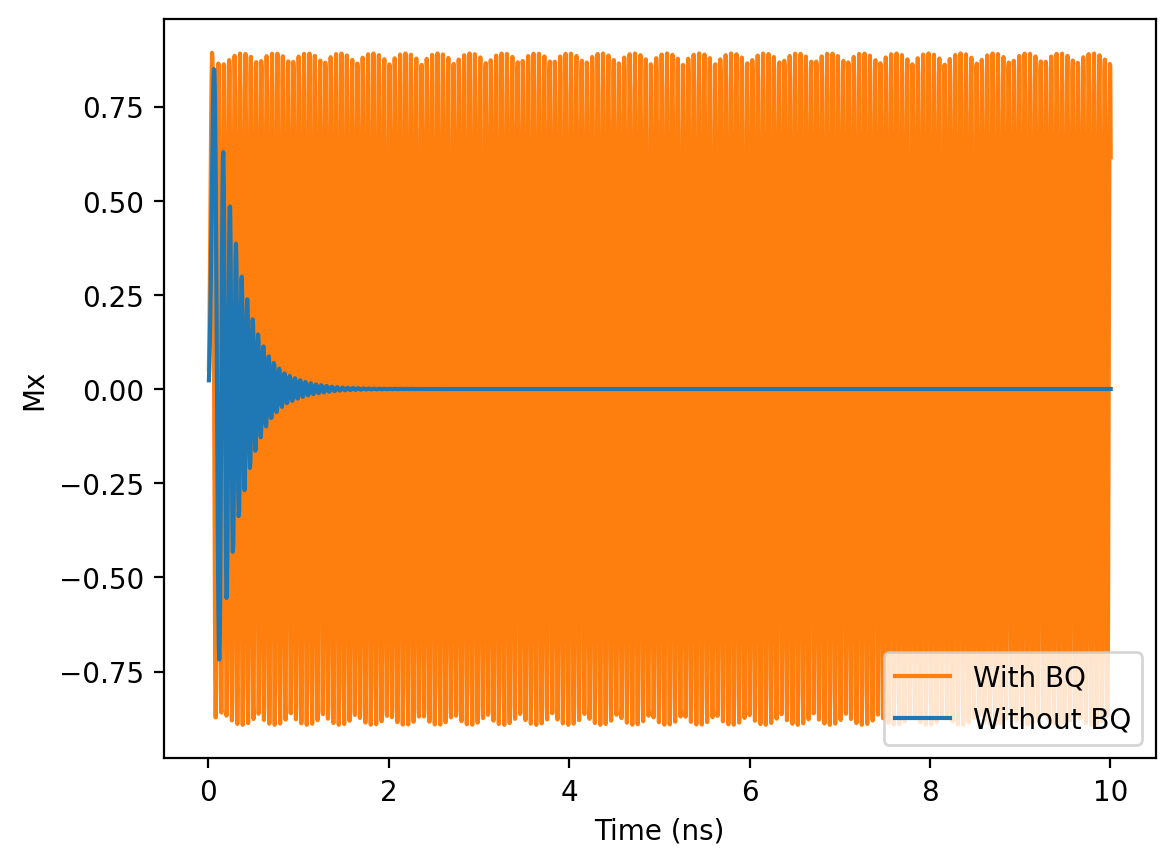

In [4]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(t_w_BQ/1e-9, mx_w_BQ, label="With BQ", color=cycle[1])
plt.plot(t_no_BQ/1e-9, mx_no_BQ, label="Without BQ", color=cycle[0])
plt.legend()
plt.xlabel("Time (ns)")
plt.ylabel("Mx")

(0.0, 971.6196448353948)

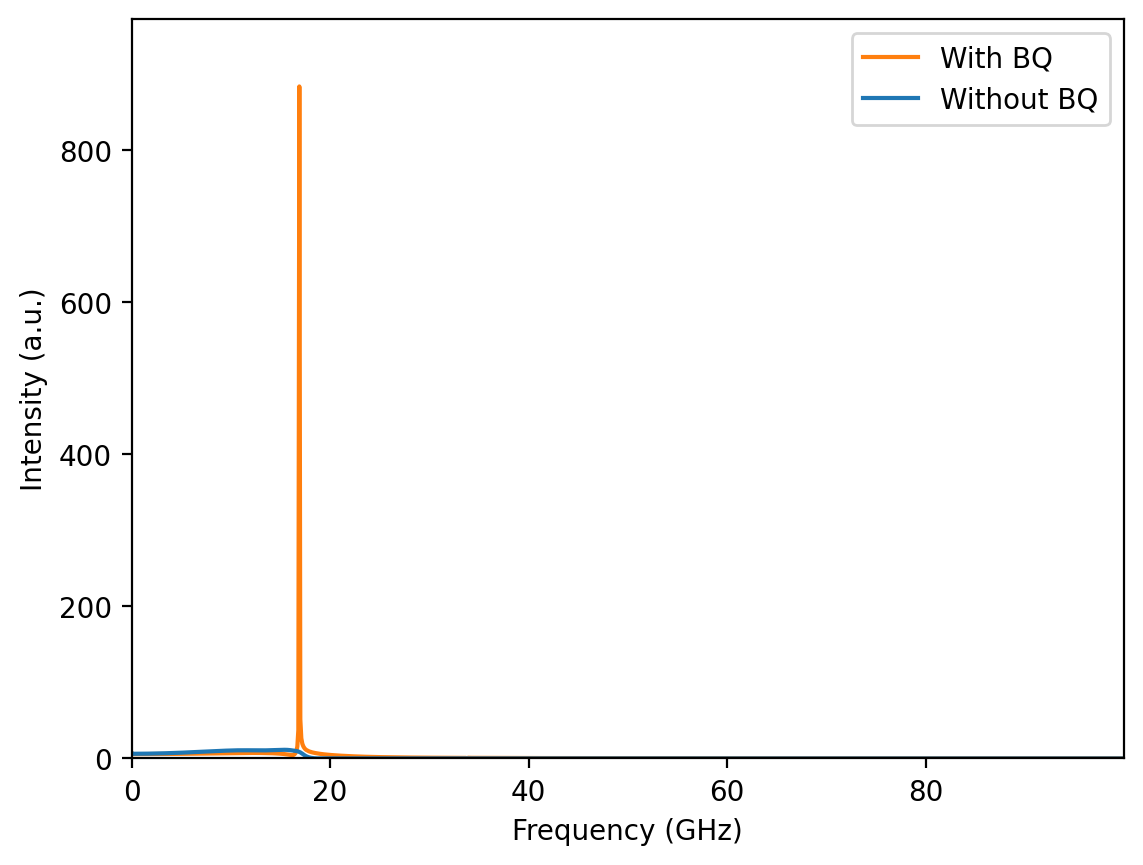

In [7]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(xf_w_BQ/1e9, np.abs(yf_w_BQ), label="With BQ", color=cycle[1])
plt.plot(xf_no_BQ/1e9, np.abs(yf_no_BQ), label="Without BQ", color=cycle[0])

plt.legend()
plt.xlabel("Frequency (GHz)")
plt.ylabel("Intensity (a.u.)")
plt.xlim(0, xf_no_BQ.max()/1e9)
plt.ylim(0, 1.1*np.abs(yf_w_BQ).max())

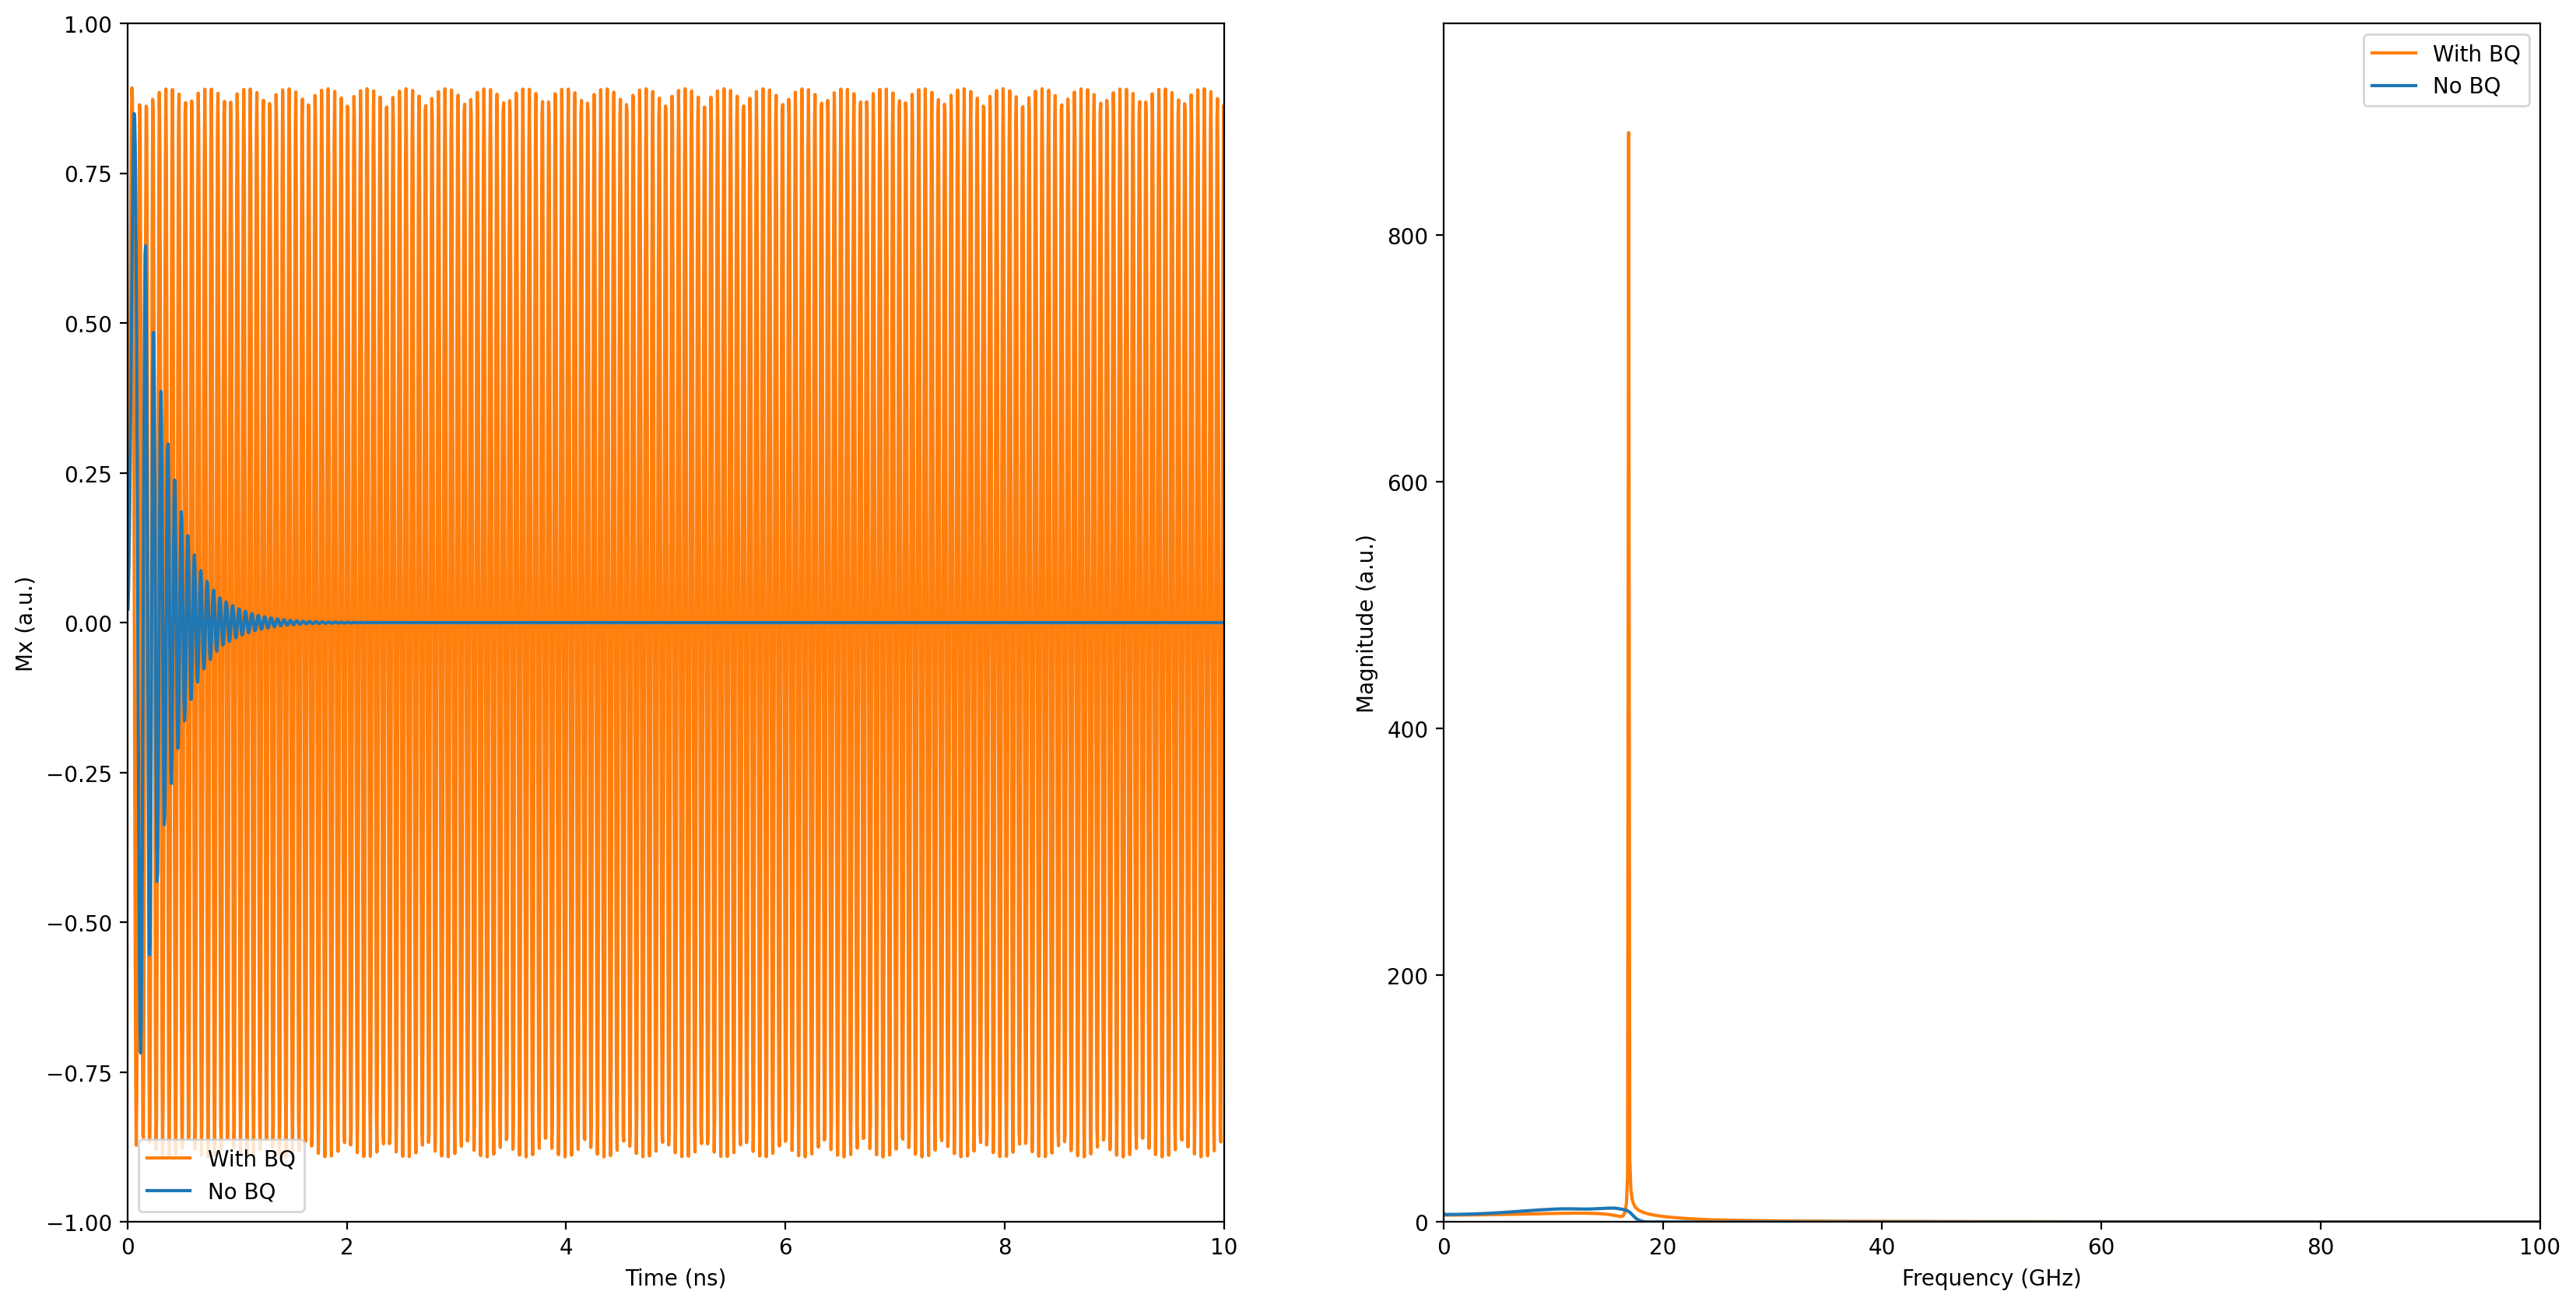

In [5]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax, fig = plt.subplots(1, 2, figsize=(20, 10))
fig[0].plot(t_w_BQ/1e-9, mx_w_BQ, label="With BQ", c=cycle[1])
fig[0].plot(t_no_BQ/1e-9, mx_no_BQ, label="No BQ", c=cycle[0])

fig[0].set_xlabel("Time (ns)")
fig[0].set_ylabel("Mx (a.u.)")
fig[0].legend()
fig[0].set_xlim(0, 10)
fig[0].set_ylim(-1, 1)


fig[1].plot(xf_w_BQ/1e9, np.abs(yf_w_BQ), label="With BQ", c=cycle[1])
fig[1].plot(xf_no_BQ/1e9, np.abs(yf_no_BQ), label="No BQ", c=cycle[0])

fig[1].set_xlabel("Frequency (GHz)")
fig[1].set_ylabel("Magnitude (a.u.)")
fig[1].legend()
fig[1].set_xlim(0, 100)
fig[1].set_ylim(0, np.abs(yf_w_BQ).max()*1.1)


plt.show()

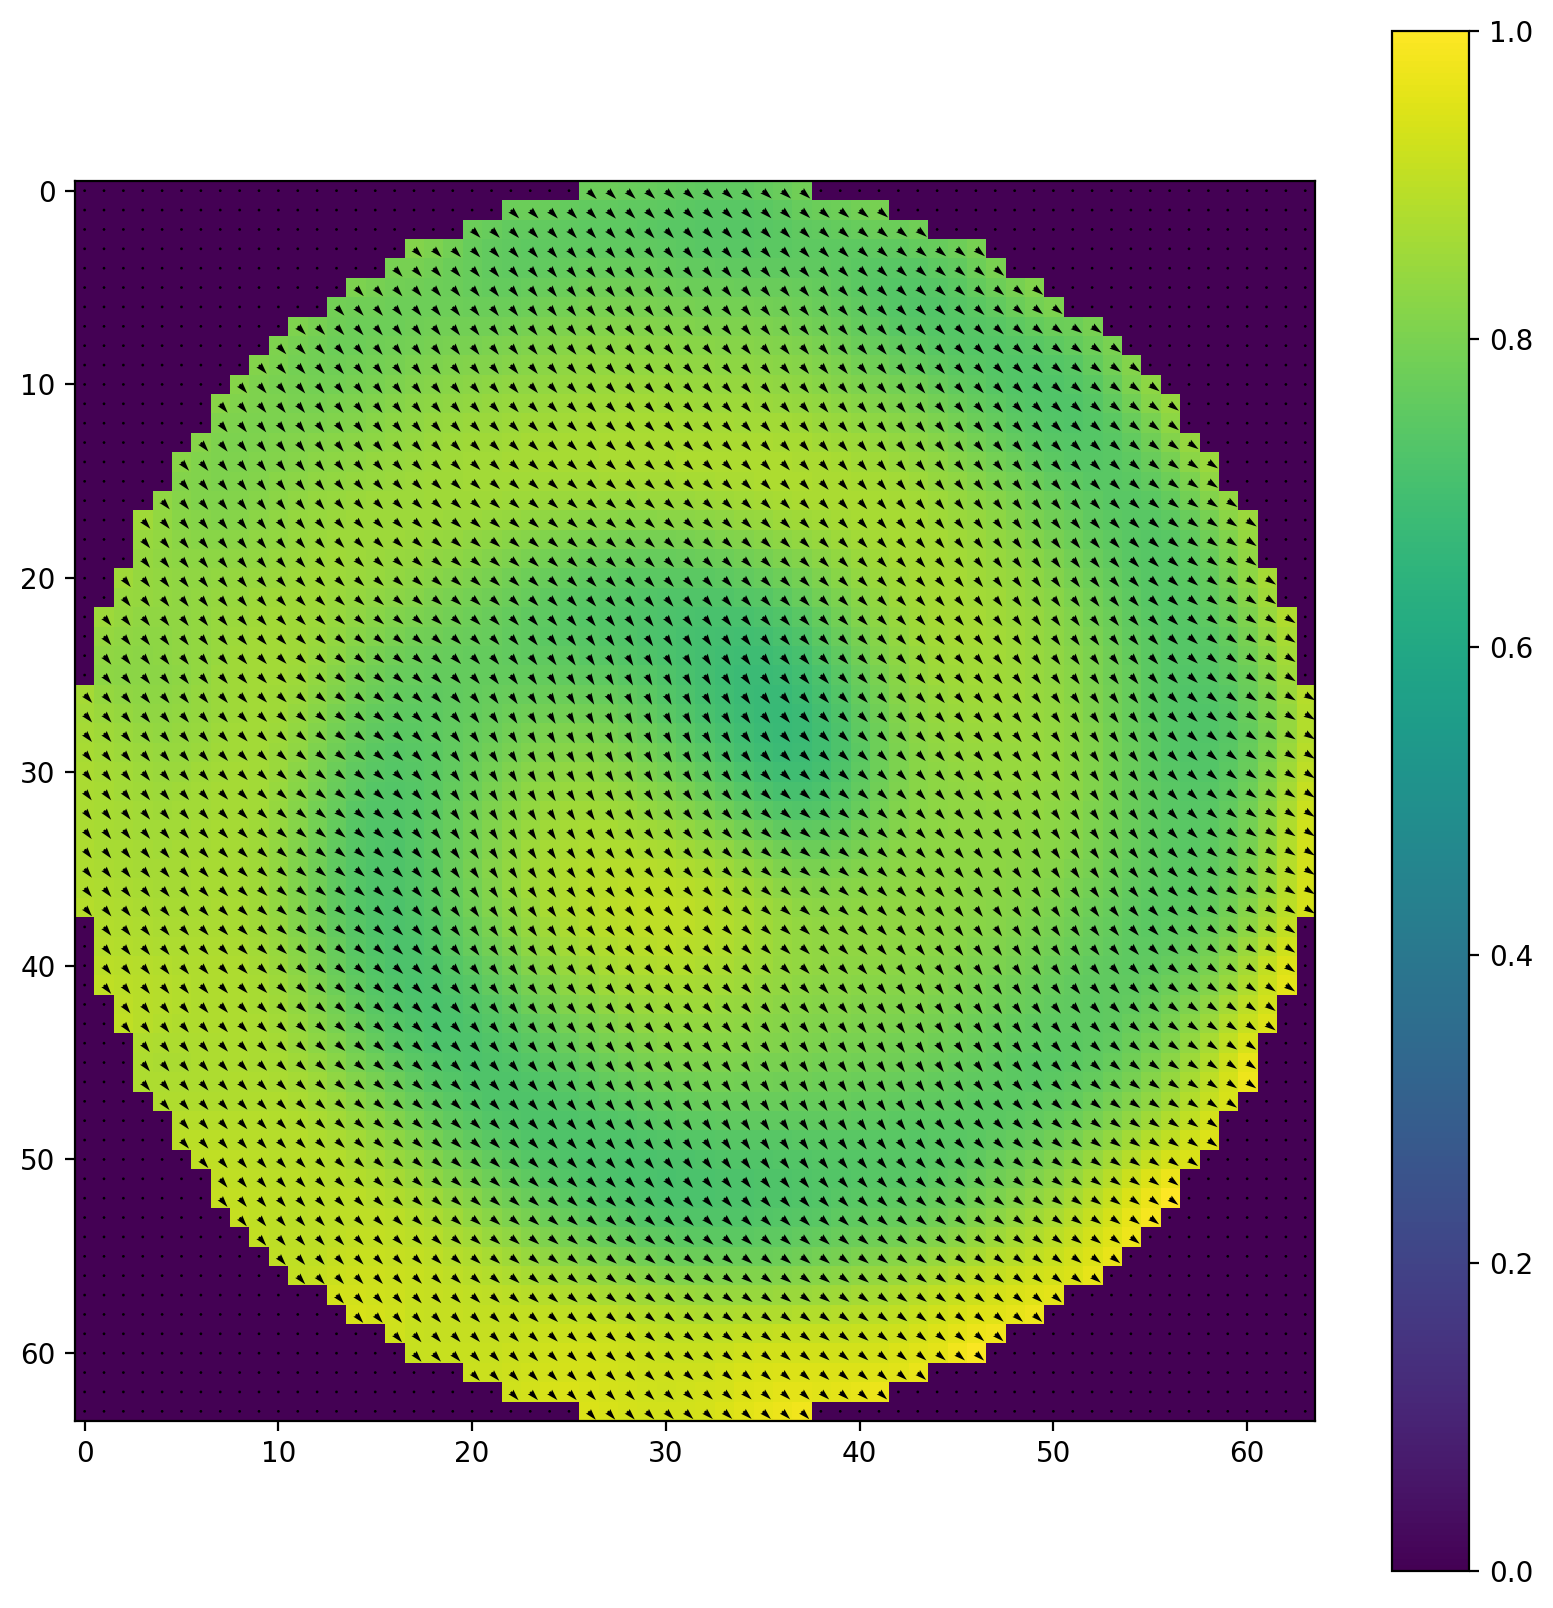

In [9]:
# Visualize the final state
m = state.m.cpu().numpy()
z_slice = 0
ax, fig = plt.subplots(figsize=(10,10))
plt.imshow(m[:,: ,z_slice, 2].T)
plt.quiver(m[:,: ,z_slice, 0].T, m[:,: ,z_slice, 1].T, scale=95)
plt.colorbar()